In [2]:
pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/664.8 MB 105.0 MB/s eta 0:00:06ERROR: Operation cancelled by user
   ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/664.8 MB 99.1 MB/s eta 0:00:06


In [1]:
!pip install ctgan table-evaluator

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
from ctgan import CTGAN
import matplotlib.pyplot as plt
import pandas as pd
from table_evaluator import TableEvaluator
from sklearn.model_selection import train_test_split
from google.colab import files

In [5]:
uploaded = files.upload()
df = pd.read_csv("diabetes_data.csv")

Saving diabetes_data.csv to diabetes_data.csv


In [6]:
df = df.drop(columns=["PatientID", "DoctorInCharge"], errors="ignore")
df = df.dropna()
discrete_columns = [col for col in df.columns if df[col].nunique() < 10]
if "Diagnosis" not in discrete_columns:
    discrete_columns.append("Diagnosis")

In [8]:
# Scale continuous columns for CTGAN
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
continuous_cols = df.select_dtypes(include='float64').columns
df_scaled = df.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df_scaled[continuous_cols])

In [9]:
# Initialize and train the CTGAN model
ctgan = CTGAN(epochs=10)  # You can adjust the number of epochs
ctgan.fit(df_scaled, discrete_columns)

In [10]:
# Identify discrete columns for CTGAN
discrete_cols = [col for col in df.columns if df[col].nunique() < 20 and col != 'Diagnosis']

In [15]:
# === 2. Train CTGAN and generate synthetic data ===
from ctgan import CTGAN
ctgan = CTGAN(epochs=300)
ctgan.fit(df_scaled, discrete_columns=discrete_cols)
synthetic_data = ctgan.sample(10000)
synthetic_data[continuous_cols] = scaler.inverse_transform(synthetic_data[continuous_cols])

In [16]:
# Evaluate the quality of the synthetic data
# Re-scale the continuous columns in synthetic data back to original scale for evaluation
synthetic_data[continuous_cols] = scaler.inverse_transform(synthetic_data[continuous_cols])

# Ensure both dataframes have the same columns in the same order
real_data = df.copy()
synthetic_data = synthetic_data[real_data.columns]

# Initialize and run the table evaluator
table_evaluator = TableEvaluator(real_data, synthetic_data)
table_evaluator.evaluate(target_col='Diagnosis') # Assuming 'Diagnosis' is your target column


Classifier F1-scores and their Jaccard similarities::
    real   fake
0 0.6669 0.6669

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (0, 0)
nearest neighbor mean                    4.6430
nearest neighbor std                     0.3447

Miscellaneous results:
                                  Result
Column Correlation Distance RMSE  0.0418
Column Correlation distance MAE   0.0314

Results:
                                                result
Basic statistics                                0.9709
Correlation column correlations                -0.0244
Mean Correlation between fake and real columns  0.9088
1 - MAPE Estimator results                      0.6669
Similarity Score                                0.6305


{'Basic statistics': 0.9709385738132107,
 'Correlation column correlations': -0.024416235409764727,
 'Mean Correlation between fake and real columns': 0.908785110012602,
 '1 - MAPE Estimator results': 0.6668757781137368,
 'Similarity Score': 0.6305458066324462}

In [17]:
# Salvează setul de date sintetice într-un fișier CSV
synthetic_data.to_csv("synthetic_diabetes_data.csv", index=False)
print("Datele sintetice au fost salvate în 'synthetic_diabetes_data.csv'")

Datele sintetice au fost salvate în 'synthetic_diabetes_data.csv'


In [18]:
# === 4. Model training ===
X = synthetic_data.drop(columns=["Diagnosis"])
y = synthetic_data["Diagnosis"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [33]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

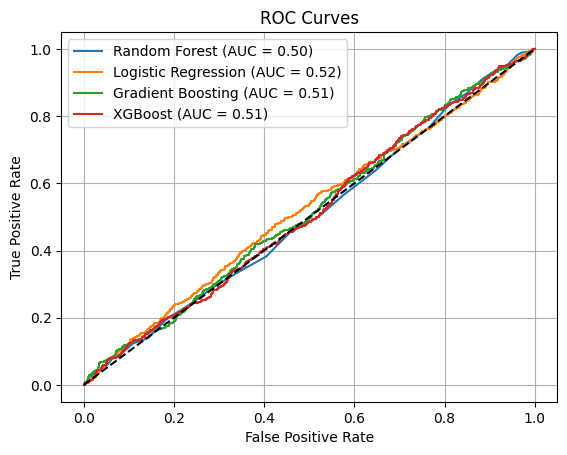

In [34]:
# === 5. Evaluate models ===
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "model": model,
        "auc": auc,
        "confusion_matrix": cm,
        "classification_report": report,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

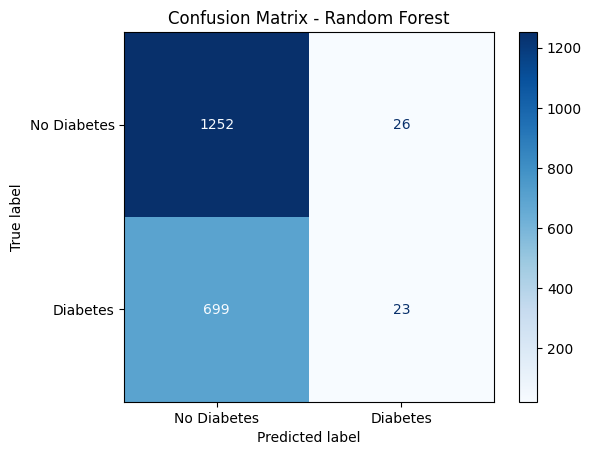

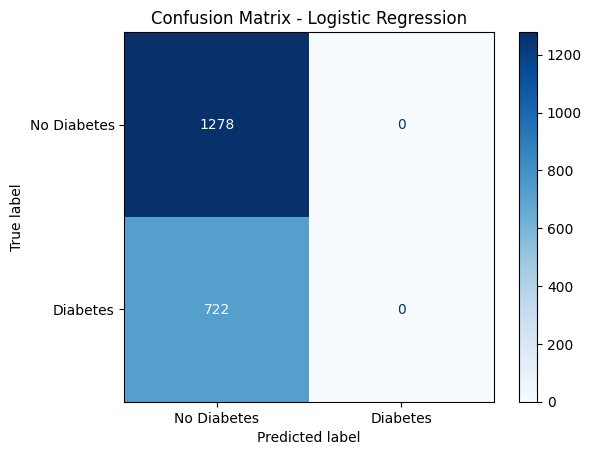

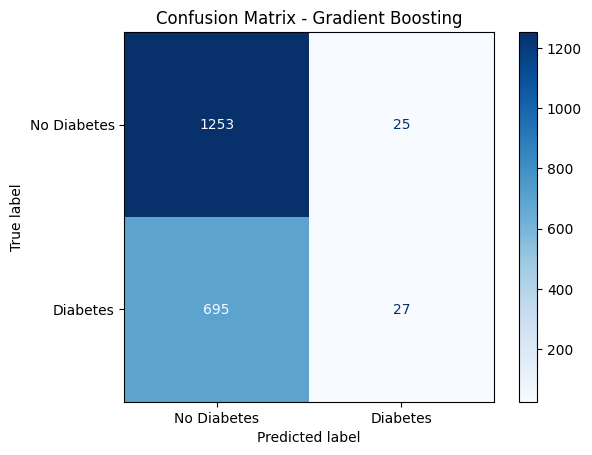

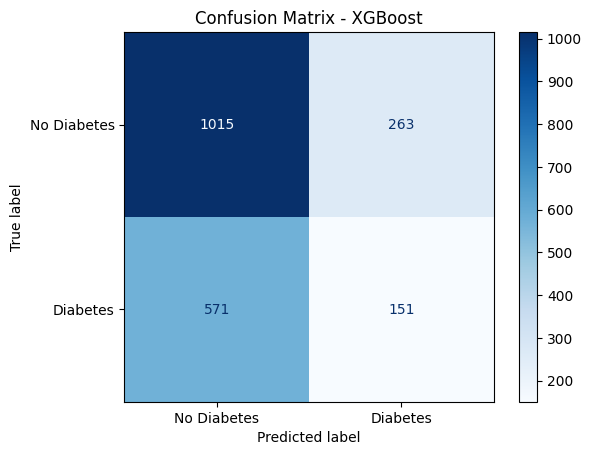

In [35]:
# === 6. Confusion Matrix ===
for name in results:
    disp = ConfusionMatrixDisplay(confusion_matrix=results[name]["confusion_matrix"],
                                   display_labels=["No Diabetes", "Diabetes"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

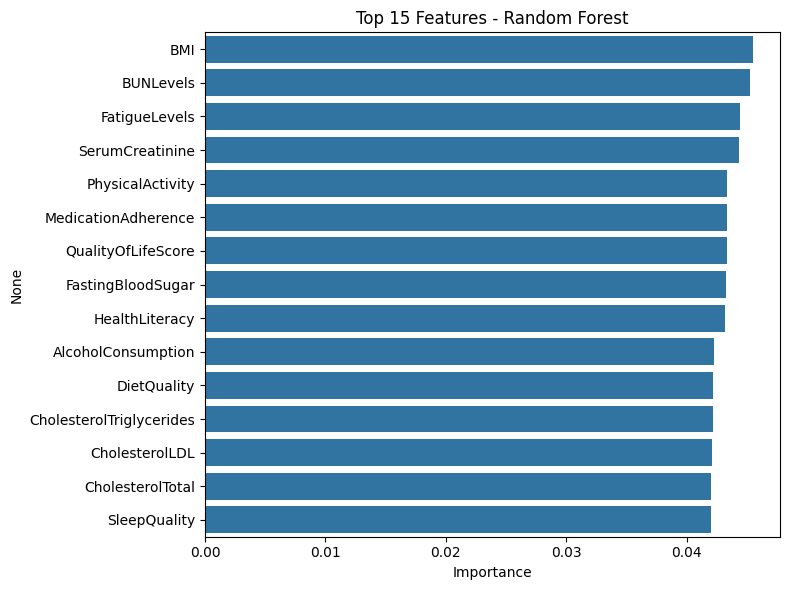

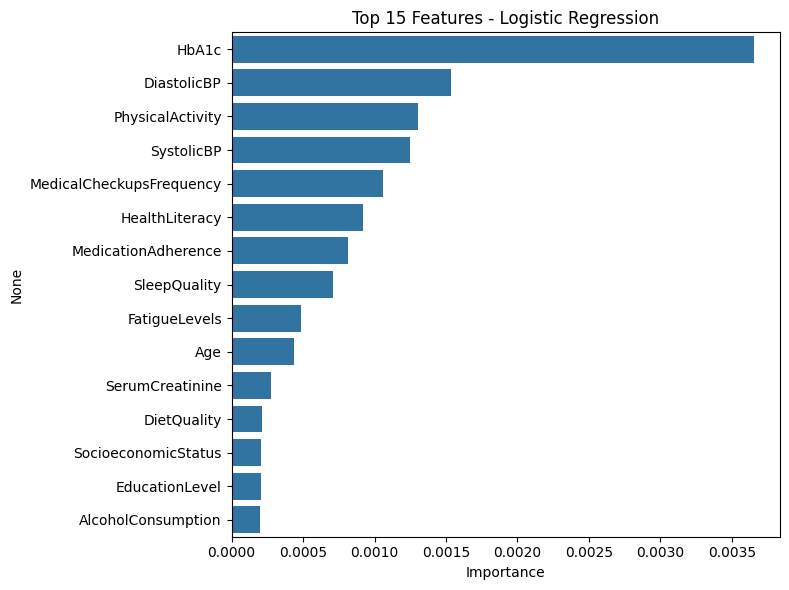

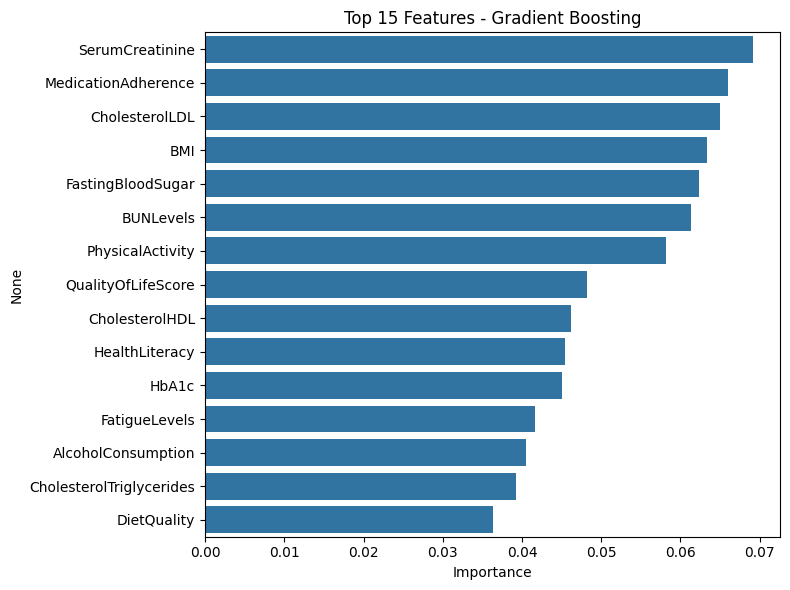

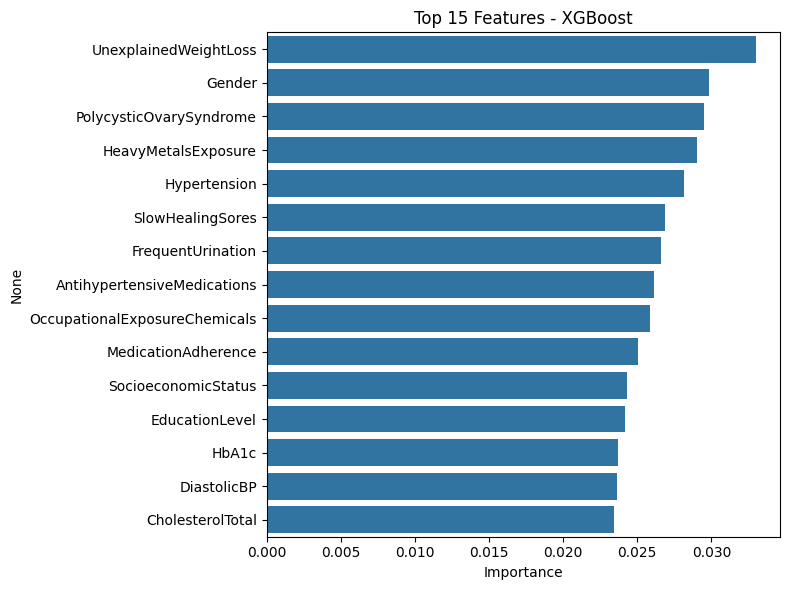

In [36]:
# === 7. Feature Importance Plots ===
for name, res in results.items():
    model = res["model"]
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = abs(model.coef_[0])
    else:
        continue

    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:15]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top 15 Features - {name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay, classification_report
)

In [39]:
uploaded = files.upload()
df = pd.read_csv("synthetic_diabetes_data 1000.csv")

Saving synthetic_diabetes_data 1000.csv to synthetic_diabetes_data 1000.csv


In [40]:
# === 2. Separare features și etichetă ===
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# === 3. Definirea modelelor ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [50]:
# === 4. Evaluare modele ===
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrici
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc
    })


# === 5. Rezumat metrici ===
performance_df = pd.DataFrame(results)
print(performance_df)

                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0        Random Forest    0.6356     0.4328  0.0322    0.0599   0.5238
1  Logistic Regression    0.6392     0.0000  0.0000    0.0000   0.5134
2    Gradient Boosting    0.6316     0.3492  0.0244    0.0456   0.5119
3              XGBoost    0.6276     0.3942  0.0599    0.1039   0.5055
